# Exploitation-Exploration tradeoff

## Multi-armed Bandits

- Read Chapter 2 from "[Reinforcement Learing - An intruction](http://incompleteideas.net/book/RLbook2020trimmed.pdf)" (Sutton and Barto, 2018), and focus on sections 2.1, 2.2, 2.3, 2.6, 2.7 and 2.10. [This is a legal copy from one of the authors.]

  - A high level overview of the chapter can be gained by watching this video: https://www.youtube-nocookie.com/embed/9LhNHK1ULxs?start=5
    
- Study the Chapter 2 code, reproduced below, from "[Re-implementations in Python by Shangtong Zhang](http://incompleteideas.net/book/code/code2nd.html)".

### Marking scheme

|Item|Mark|
|:----|---:|
|Experimet 1|/4|
|Experimet 2|/4|
|Experimet 3|/4|
|Experimet 4|/4|
|Experimet 5|/4|
|||
|**Total**:     |/20|


The tasks for assessment are:
1. Set the **random-numbe-generator seed** to be your student ID. (See `np.random.seed(.....)` below.)
2. Choose a value for $k$ from the set $\{7, 8, 9, 10, 11, 12\}$ (i.e. `k_arm=....`).
3. Devise and run 5 computational experiments to study the effect of the parameters `epsilon`, `initial`, `step_size`, `sample_averages`, `UCB_param`, `gradient`.

    For each experiment:
    - Explain what its aim is.
    - Explain what parameters are being used, and what they are meant to control.
    - Use diagrams to show your results, then discuss them.
    
    Your experiments must be sufficiently distinct from those presented below (which reproduce experiments in the book). For example, you may try a wider range of $\varepsilon$ values to try and find an optimal value. You should also look into the initial distributions of the bandits' values.
    
**NB** Note that the values for `MAX_RUNS = 100` `MAX_TIME = 300` are low to make the code faster. You will need to increase these at the final run to get smoother results.

In [2]:
import numpy as np
from numpy.random import rand, randn, choice

np.random.seed(12998157)   ##   ---   SET THIS TO YOUR SID   ---   ##

In [3]:
##   ---   Increase these values at the last run to get smoother statistics   ---   ##
MAX_RUNS = 600
MAX_TIME = 800

In [4]:
##   ---   Increase these values at the last run to get smoother statistics   ---   ##
MAX_RUNS = 500
MAX_TIME = 800

In [5]:
# Adapted by Kamal Bentahar (2022) from:
# https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter02/ten_armed_testbed.py

#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import matplotlib
import matplotlib.pyplot as plt
from tqdm import trange

In [6]:
class Bandit:
    # @k_arm:             number of arms
    # @epsilon:           probability for exploration in epsilon-greedy algorithm
    # @initial:           initial estimation for each action
    # @step_size:         constant step size for updating estimations
    # @sample_averages:   if True, use sample averages to update estimations instead of constant step size
    # @UCB_param:         if not None, use UCB algorithm to select action
    # @gradient:          if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm

    def __init__(self, k_arm=9, epsilon=0.2, initial=6.0, step_size=0.4, sample_averages=False,
                 UCB_param=None, gradient=False, gradient_baseline=False, true_reward=0.0):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial

    def reset(self):        
        self.q_true = randn(self.k) + self.true_reward  # real reward for each action
        self.q_estimation = np.zeros(self.k) + self.initial  # estimation for each action
        self.action_count = np.zeros(self.k)  # number of chosen times for each action
        self.best_action = np.argmax(self.q_true)
        self.time = 0

    def act(self):
        ''' Get an action for this bandit '''
        if rand() < self.epsilon:
            return choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation
            UCB_estimation += self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return choice(np.where(self.q_estimation == q_best)[0])

    def step(self, action):
        ''' Take an action, update estimation for this action '''
        # generate the reward under N(real reward, 1)
        reward = randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
        if self.sample_averages:  # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            baseline = self.average_reward if self.gradient_baseline else 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:  # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward

In [7]:
def simulate(runs, time, bandits):
    ''' Returns: mean_best_action_counts, mean_rewards '''
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

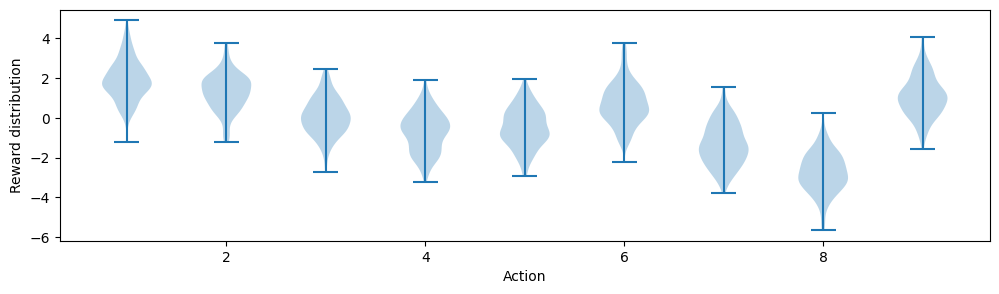

In [8]:
def figure_2_1(k=9):
    plt.figure(figsize=(12, 3))
    plt.violinplot(dataset=randn(200, k) + randn(k))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")
    plt.show()
figure_2_1()

100%|██████████| 200/200 [00:35<00:00,  5.66it/s]


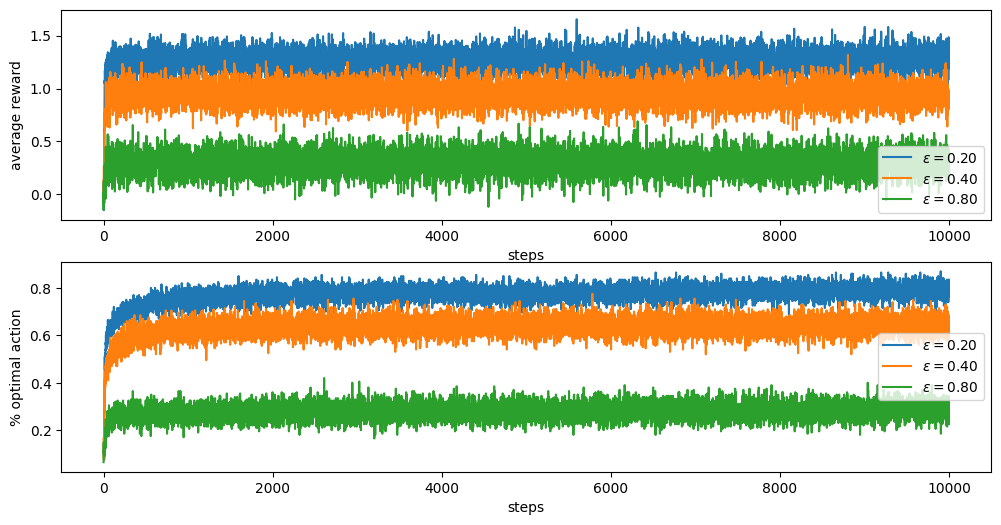

In [9]:
def figure_2_2(runs=MAX_RUNS, time=MAX_TIME):
    epsilons = [0.2,0.4,0.8]
    bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards, label=f'$\epsilon = {eps:.02f}$')
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()

    plt.subplot(2, 1, 2)
    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label=f'$\epsilon = {eps:.02f}$')
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.show()
figure_2_2(200, 10000)

100%|██████████| 500/500 [00:07<00:00, 63.49it/s]


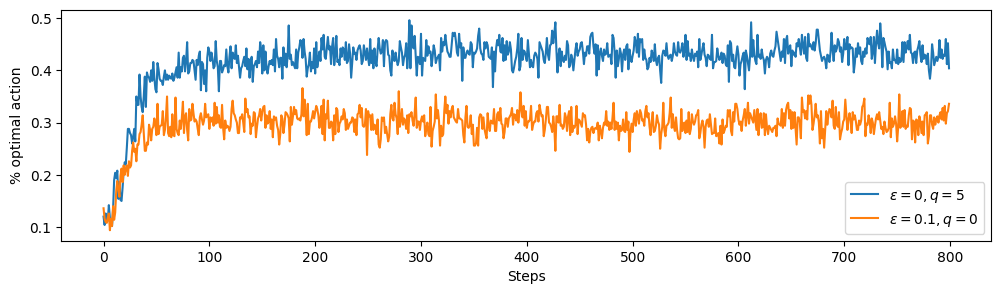

In [10]:
def figure_2_3(runs=MAX_RUNS, time=MAX_TIME):
    bandits = []
    bandits.append(Bandit(epsilon=0.4, initial=6, step_size=0.5))
    bandits.append(Bandit(epsilon=0.6, initial=4, step_size=0.5))
    best_action_counts, _ = simulate(runs, time, bandits)

    plt.figure(figsize=(12, 3))
    plt.plot(best_action_counts[0], label='$\epsilon = 0, q = 5$')
    plt.plot(best_action_counts[1], label='$\epsilon = 0.1, q = 0$')
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.show()
figure_2_3()

100%|██████████| 500/500 [00:08<00:00, 56.95it/s]


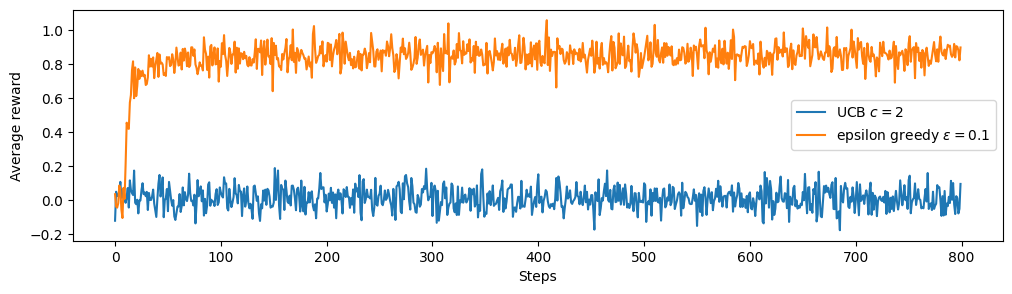

In [11]:
def figure_2_4(runs=MAX_RUNS, time=MAX_TIME):
    bandits = []
    bandits.append(Bandit(epsilon=0.2, UCB_param=6, sample_averages=True))
    bandits.append(Bandit(epsilon=0.4, sample_averages=True))
    _, average_rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(12, 3))
    plt.plot(average_rewards[0], label='UCB $c = 2$')
    plt.plot(average_rewards[1], label='epsilon greedy $\epsilon = 0.1$')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()
    plt.show()
figure_2_4()

100%|██████████| 500/500 [00:16<00:00, 30.88it/s]


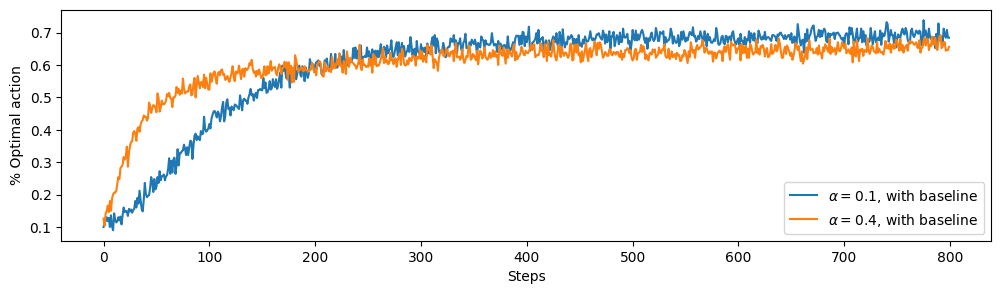

In [12]:
def figure_2_5(runs=MAX_RUNS, time=MAX_TIME):
    bandits = []
    bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
    bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False))
    best_action_counts, _ = simulate(runs, time, bandits)
    labels = [r'$\alpha = 0.1$, with baseline',
              r'$\alpha = 0.4$, with baseline'
             ]

    plt.figure(figsize=(12, 3))
    for i in range(len(bandits)):
        plt.plot(best_action_counts[i], label=labels[i])
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.legend()
    plt.show()
figure_2_5()

In [ ]:
def figure_2_6(runs=MAX_RUNS, time=MAX_TIME):
    labels = ['epsilon-greedy', 'gradient bandit',
              'UCB', 'optimistic initialization']
    generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
                  lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
                  lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
                  lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
    parameters = [np.arange(-7, -1, dtype=float),
                  np.arange(-5, 2, dtype=float),
                  np.arange(-4, 3, dtype=float),
                  np.arange(-2, 3, dtype=float)]

    bandits = []
    for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits.append(generator(2**param))

    _, average_rewards = simulate(runs, time, bandits)
    rewards = np.mean(average_rewards, axis=1)

    plt.figure(figsize=(12, 3))
    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, rewards[i:i+l], label=label)
        i += l
    plt.xlabel('Parameter ($2^x$)')
    plt.ylabel('Average reward')
    plt.legend()
    plt.show()
figure_2_6()

# EXPERIMENT

100%|██████████| 200/200 [00:37<00:00,  5.34it/s]


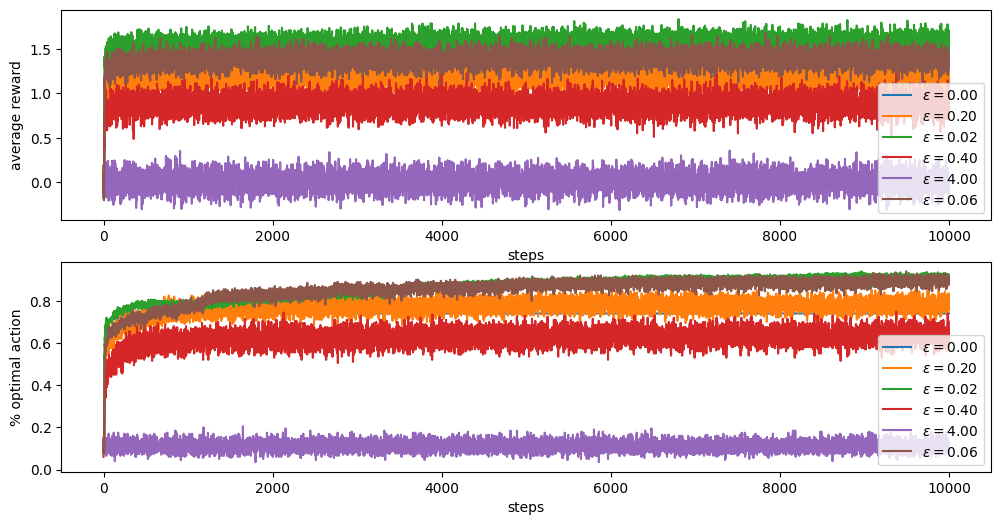

In [ ]:
def experiment1(runs=MAX_RUNS, time=MAX_TIME):
    epsilons = [0,0.2,0.02,0.4,4,0.06]
    bandits = [Bandit(epsilon=eps, sample_averages=True, k_arm=9) for eps in epsilons]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    for eps, rewards in zip(epsilons, rewards):
        plt.plot(rewards, label=f'$\epsilon = {eps:.02f}$')
    plt.xlabel('steps')
    plt.ylabel('average reward')
    plt.legend()

    plt.subplot(2, 1, 2)
    for eps, counts in zip(epsilons, best_action_counts):
        plt.plot(counts, label=f'$\epsilon = {eps:.02f}$')
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.show()
experiment1(200, 10000)

# aim 
The parameter epsilon, which determines the possibility of selecting a random action, effects this trade-off and agent performance in this experiment. When epsilon is larger, the agent is more likely to choose a random action, boosting its chances of exploring new states and finding a better policy. When epsilon is low, the agent is more likely to pick the action with the highest expected reward based on its current knowledge, boosting the agent's odds of implementing the optimal policy it has learned. The experiment demonstrates how the exploration-exploitation trade-off changes as epsilon rises, and how this affects the agent's overall proportion of optimal behaviour. This data can be used to fine-tune the epsilon value in order to balance exploration and exploitation and to evaluate reinforcement learning systems.

# what parameters are being used, and what they are meant to control.
 Epsilon handles multi-armed bandit exploration-exploitation trade-offs. Epsilon affects the agent's likelihood of choosing exploration over the greatest projected payoff based on its present knowledge. (exploitation). If epsilon is 0.1, the agent will choose a random action 10% of the time and the highest projected payout 90%.
 
 Multi-armed bandit issues estimate action rewards using sample averages. Sample averages adjust each action's expected reward by averaging its previous rewards. In contrast, the constant step-size method updates each action's predicted reward by a fixed step-size number.

 K-armed bandits involve reinforcement learning with k possible actions. (arms). Over time, the agent must learn the highest expected payoff arm. Each arm of the agent is a slot machine with random payouts. K-armed bandits demonstrate the exploration-exploitation trade-off.

# graph
Reinforcement learning explores-exploits. When epsilon is low (0.02, 0.06), the agent uses its knowledge and chooses the action with the highest predicted return. (exploration). The agent will find the best policy faster and investigate poor actions less. Epsilon increases the agent's chance of taking a random action and finding a better policy. The agent will spend more time exploring than using its information, which may slow convergence and performance. Thus, if the epsilon value is too large, the agent will explore too much and exploit too little, resulting in a lower average payout and fewer optimum actions. The agent abuses and explores too much if epsilon is too low.

# EXPERIMENT 2

100%|██████████| 200/200 [00:28<00:00,  7.04it/s]


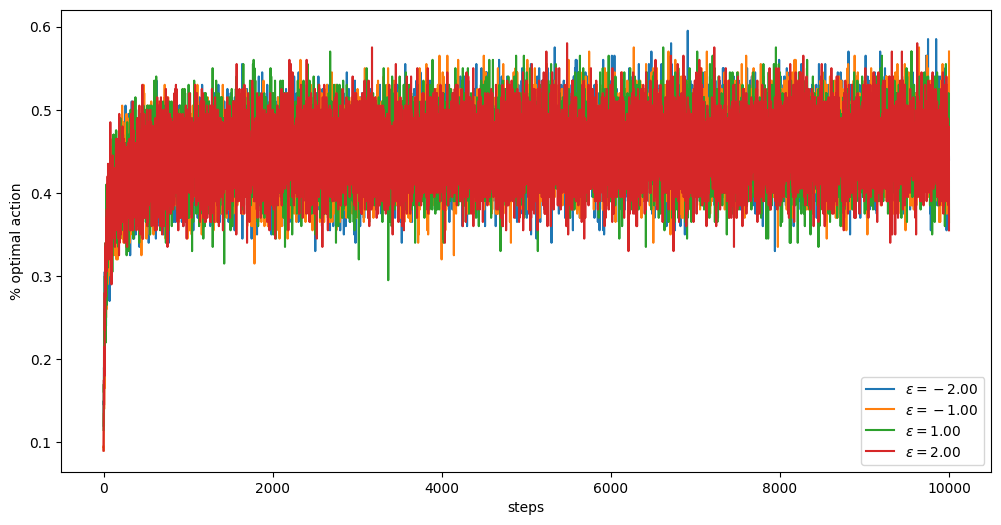

In [ ]:
def experiment2(runs=MAX_RUNS, time=MAX_TIME):
    initials = [-2,-1,1,2,]
    bandits = [Bandit(epsilon=0.6, sample_averages=True, k_arm=9, initial=inti) for inti in initials]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(12, 6))
    for inti, count in zip(initials, best_action_counts):
        plt.plot(count, label=f'$\epsilon = {inti:.02f}$')
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.show()
experiment2(200, 10000)

# aim 
Before collecting data, multi-armed bandit challenges begin with the predicted payment for each move. Agent behaviour and policy learning speed are influenced by the initial value. If the initial value is high, the agent will prioritise non-greedy behaviours since they appear to be more promising. Optimism regarding non-greedy incentives. The agent will become greedier as it learns more and alters its estimates. The agent will be greedy because the original estimate is low. Convergence may be hampered by low initial estimations and insufficient study. As a result, the initial value affects the exploration-exploitation balance and the optimal policy learning rate. Low beginning values promote exploitation, whereas high initial values promote exploration.

# parameters and meaning 

Reinforcement learning's starting value predicts action rewards before data collection. This number guides the agent's first actions. Data improves agent predictions and decisions. 

Sample averages evaluate each action's reward using all preceding payouts. After each action, estimate or average all awards won. (sample mean). 

Agent bandit count is K-arms. The agent must choose the bandit with the largest payment as often as possible.

# graph 
According to the graph of the ideal action rate%, it would seem that changing the starting value has a negligible influence on the ideal action rate. According to the graph, the ideal action rate appears to be unaffected by whether the beginning value is positive or negative. However, when the starting value is far from zero, there is a small fluctuation in the optimal action rate, and values that are closer to zero produce a slightly superior ideal action rate. Only when the initial value is extremely far from zero is this distinction apparent.

# EXPERIMENT 3 

100%|██████████| 200/200 [00:28<00:00,  6.90it/s]


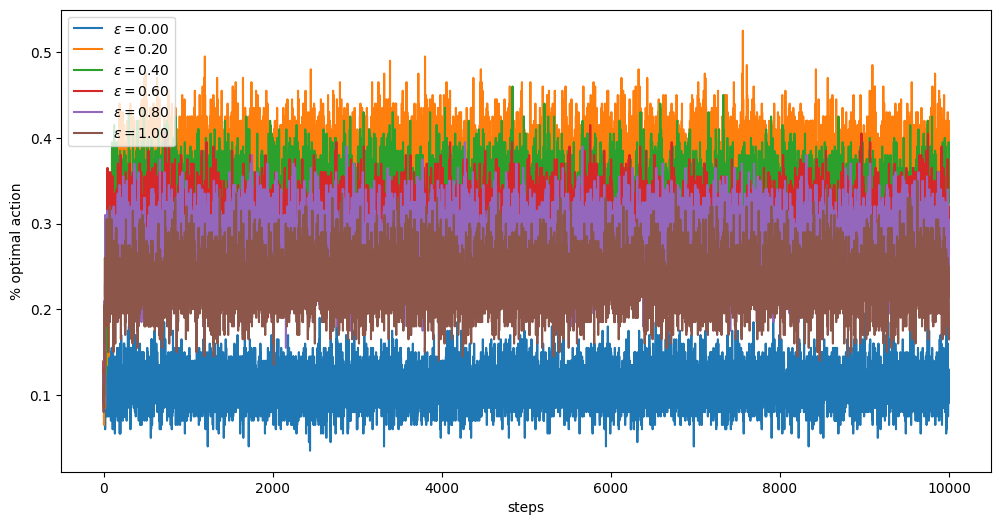

In [ ]:
def experiment3(runs=MAX_RUNS, time=MAX_TIME):
    stepsize = [0,0.2,0.4,0.6,0.8,1]
    bandits = [Bandit(epsilon=0.6, step_size=ss,gradient_baseline=True, k_arm=9, ) for ss in stepsize]
    best_action_counts, rewards = simulate(runs, time, bandits)

    plt.figure(figsize=(12, 6))
    for ss, count in zip(stepsize, best_action_counts):
        plt.plot(count, label=f'$\ stepsize= {ss:.02f}$')
    plt.xlabel('steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.show()
experiment3(200, 10000)

# aim
This experiment's goal is to examine how changing the step size affects the frequency with which the optimal strategy is evaluated. Specifically, the experiment will look at the relationship between these two variables. Upon the acquisition of each new data point, the agent's estimations of the potential rewards resulting from each course of action are modified in accordance with the alpha value. Altering the value of alpha allows for greater control over the rate at which the agent will eventually converge on the optimal next step. If the agent increases alpha, they may arrive at the optimum course of action more quickly; yet, if the agent decreases alpha, they may arrive at the best course of action more slowly.

# parameters and meaning
Throughout the process of learning, the frequency with which the action that leads to the best outcome is evaluated is controlled by a parameter known as step size . If the value of alpha is increased, it indicates that the best course of action will be examined less frequently during the course of the learning process. 

The term "gradient baseline" refers to a technique that is utilised in gradient-based optimisation algorithms. In these algorithms, the average reward serves as the technique's baseline. The gradient update is calculated by deducting this baseline from the most recent estimate of the reward that will be received for each action.

# graph 
The % optimal action graph shows that as the value of  the step size decreases, so does the likelihood of choosing the optimal action. This is due to the fact that a smaller step size requires the agent to update its estimates of the reward for each action more frequently, resulting in more accurate estimates of the rewards. 

The step size is used to compute the average of previous rewards for each action. A smaller step size means that the agent measures this average at smaller intervals, resulting in a more fine-grained estimate of the reward for each action. This more precise estimate allows the agent to make more informed decisions about which action to take.

# Conclusion

The aim of the experiment is to maximize the reward time .setting the student id 12998157 and randomly generating the k-arm =9 value the range for this is from 1........10 .

The tests demonstrated how successful employing RL can be in resolving complicated issues, as well as how different hyperparameters can have an impact on a system's overall performance. It is absolutely necessary to choose the suitable method of analysis and cautiously study the graphs in order to observe the difference in performance


# List of references

: The Multi-Arm Bandit Problem in Python.2022 https://www.askpython.com/python/examples/bandit-problem-in-python.

 Reinforcement Learning Guide: Solving the Multi-Armed Bandit Problem from Scratch in Python,2018 https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/.

Multi-Armed Bandits in Python: Epsilon Greedy, UCB1, Bayesian UCB, and EXP3.,James LeDoux. (2022).  https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/.
http://incompleteideas.net/book/RLbook2020trimmed.pdf - Reinforcement learning book